# Run confounding shift on positive ratio for gender prediction

In [1]:
import sys
import os

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics
from tqdm.notebook import tqdm


import torch

from src.utils import confoundSplit, confoundSplitNumbers, confoundSplitDF

from src.MultiLabel import TransformerDataset, MultiLabel
from src.MultiClassificationNN import MultiClassificationNN
from src.BinaryClassificationNN import BinaryClassificationNN

## Load data Dementia

In [4]:
df = pd.read_csv('./processed_db.csv', index_col=0)
df_wls = df[df['source'] == 0]
df_pitts = df[df['source'] == 1]

In [5]:
df.head()

,file,gender,age,text,source,target
0,2000000002,1,71.0,I see a woman washing dishes. the sink is over...,0,wls_female
1,2000000007,1,66.0,okay. I see a girl. I see a boy a cookie jar c...,0,wls_female
2,2000000032,1,71.0,well there's a cookie jar. there's the cover o...,0,wls_female
3,2000000047,1,71.0,okay um a girl and a boy. he's standing on a s...,0,wls_female
4,2000000054,1,70.0,well the boy is getting the getting a cookie j...,0,wls_female


- distribution of traget variable

In [6]:
df.gender.value_counts()

1    731
0    579
Name: gender, dtype: int64

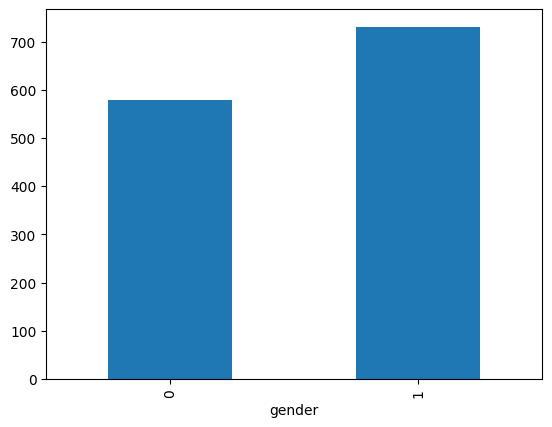

In [7]:
df.groupby("gender").size().plot.bar()
pass

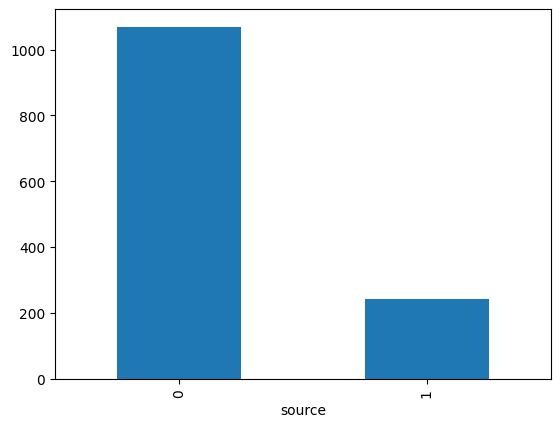

In [8]:
df.groupby("source").size().plot.bar()
pass

In [9]:
df.gender.value_counts()/len(df)

1    0.558015
0    0.441985
Name: gender, dtype: float64

In [10]:
df.source.value_counts()/len(df)

0    0.816031
1    0.183969
Name: source, dtype: float64

## Model Config

In [11]:
num_labels = 2


pretrained = 'bert-base-uncased'
device = 'cuda:0'

max_length = 120
num_epochs = 10
hidden_dropout_prob = 0.1
num_warmup_steps = 0
batch_size = 30


lr = 1e-6
grad_norm = 1.0
balance_weights = False

In [12]:
model_config = {}
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm

## Combination Runs

In [6]:
df_pitts.gender.value_counts()/len(df_pitts)

1    0.639004
0    0.360996
Name: gender, dtype: float64

In [7]:
df_wls.gender.value_counts()/len(df_wls)

1    0.539757
0    0.460243
Name: gender, dtype: float64

In [6]:
len(df)

1310

In [10]:
n_test = 100 # the number of testing examples; set to None to disable (i.e., get as many examples as possible)
n_test_error = 5

p_wls = (df_wls.gender.value_counts()/len(df_wls))[1]
p_pitts = (df_pitts.gender.value_counts()/len(df_pitts))[1]

p_z1_mix = (df.source.value_counts()/len(df))[1]


# p_wls = 0.54
# p_pitts = 0.64
# p_z1_mix = 0.18

valid_high_combinations = []
valid_full_settings = []
for combination in itertools.product([p_wls], 
                                    [p_pitts], 
                                    [p_z1_mix],
                                     np.arange(0, 4, 0.1), #range alpha from 0 to 4
                                     [4], # train/test ratio
                                     [n_test],
                                     [n_test_error]
                                    ):
    
    ret = confoundSplitNumbers(df0=df_wls, df1=df_pitts, 
                        df0_label='gender', df1_label='gender',

                        p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                        train_test_ratio = combination[4], 
                            n_test=n_test, n_test_error=n_test_error
                       )
   
    if (ret is not None) and (ret['n_df0_train_pos'] >= 1): # valid high combos
        valid_high_combinations.append(combination)
        valid_full_settings.append(ret)
    

In [1]:
len(valid_full_settings)

NameError: name 'valid_full_settings' is not defined

In [12]:
valid_full_settings

[{'n_df0_train_pos': 531,
  'n_df0_test_pos': 46,
  'n_df0_train_neg': 125,
  'n_df0_test_neg': 22,
  'n_df1_train_pos': 93,
  'n_df1_test_pos': 20,
  'n_df1_train_neg': 54,
  'n_df1_test_neg': 16,
  'mix_param_dict': {'p_pos_train_z0': 0.539756782039289,
   'p_pos_train_z1': 0.6390041493775933,
   'p_pos_train': 0.5580152671755725,
   'p_pos_test': 0.5580152671755725,
   'p_mix_z0': 0.816030534351145,
   'p_mix_z1': 0.18396946564885497,
   'alpha_train': 1.1838742386215724,
   'alpha_test': 0.1,
   'p_pos_test_z0': 0.6687402799377915,
   'p_pos_test_z1': 0.06687402799377916,
   'C_y': 0.5580152671755725,
   'C_z': 0.18396946564885497},
  'n_train': 803,
  'n_test': 104},
 {'n_df0_train_pos': 537,
  'n_df0_test_pos': 40,
  'n_df0_train_neg': 112,
  'n_df0_test_neg': 21,
  'n_df1_train_pos': 93,
  'n_df1_test_pos': 35,
  'n_df1_train_neg': 53,
  'n_df1_test_neg': 1,
  'mix_param_dict': {'p_pos_train_z0': 0.539756782039289,
   'p_pos_train_z1': 0.6390041493775933,
   'p_pos_train': 0.558

In [17]:
losses_dict = {}

losses_dict['combination'] = []
losses_dict['full_setting']=[]
losses_dict['losses'] = []
losses_dict['auroc'] = []
losses_dict['auprc'] = []
losses_dict['acc'] = []

random.seed(23)


In [18]:
for c,setting in tqdm(zip(valid_high_combinations, valid_full_settings), total=len(valid_high_combinations)):
    losses_dict['combination'].append(c)
    losses_dict['full_setting'].append(setting)
    
    losses = []
    _auroc = []
    _auprc = []    
    _acc = []
    
    for i in range(5):
        _rand = random.randint(0,1000)    

        combination = c
        # combination = (0.201, 0.6, 0.3, 1.0, 4)
        # combination = (0.201, 0.7, 0.5, 1.4, 4)
        ret = confoundSplitDF(df0=df_wls, df1=df_pitts, 
                              df0_label='gender', df1_label='gender',
                              p_pos_train_z0=combination[0], 
                              p_pos_train_z1 = combination[1], 
                              p_mix_z1 = combination[2], 
                              alpha_test = combination[3],
                              train_test_ratio = combination[4],
                              random_state= _rand,
                              n_test=combination[5],
                              n_test_error=combination[6]
                                   )

        df_train = pd.concat(
                [
                    ret["sample_df0_train"][["text", "gender"]],
                    ret["sample_df1_train"][["text", "gender"]],
                ],
                ignore_index=True,
            )

        df_test = pd.concat(
                [
                    ret["sample_df0_test"][["text", "gender"]],
                    ret["sample_df1_test"][["text", "gender"]],
                ],
                ignore_index=True,
            )


        X_train = df_train["text"]
        y_train = df_train[["gender"]]

        X_test = df_test["text"]
        y_test = df_test[["gender"]]



 
        model = BinaryClassificationNN(**model_config)

        model.load_pretrained()

        model.trainModel(
                X=X_train, y=y_train, device="cuda:0"
            )



        y_pred, y_prob = model.predict(
                X=X_test, device="cuda:0"
            )

        

        # collect metrics: loss, auroc, auprc, f1
        loss = torch.nn.NLLLoss()

        _loss = loss(
            torch.log(torch.tensor(y_prob.values)),
            torch.tensor(y_test.values).squeeze(1),
        )

        losses.append(_loss.item())

        
        _auroc.append(
            metrics.roc_auc_score(
                y_true=y_test.values,
                y_score=y_prob.max(axis = 1),
            )
        )
        _auprc.append(
            metrics.average_precision_score(
                y_true=y_test.values,
                y_score=y_prob.max(axis = 1),
            )
        )
        
        _acc.append(
            metrics.accuracy_score(
                y_true = y_test.values,
                y_pred = y_pred
            )
        )
        #_f1_at_05.append(metrics.f1_score(y_true=y_test.values, y_pred=y_pred))
    
    losses_dict['losses'].append(losses)
    losses_dict['auroc'].append(_auroc)
    losses_dict['auprc'].append(_auprc)
    losses_dict['acc'].append(_acc)

  0%|          | 0/39 [00:00<?, ?it/s]

### Visualization

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
def getTestPos(c, z):
    ret = confoundSplitNumbers(df0=df_wls, df1=df_pitts, 
                            df0_label='gender', df1_label='gender',

                            p_pos_train_z0=c[0], p_pos_train_z1 = c[1], p_mix_z1 = c[2], alpha_test = c[3],

                            train_test_ratio = c[4],
                           )
    if z == "z0":
        
        return ret['mix_param_dict']['p_pos_test_z0']
    elif z == "z1":
        return ret['mix_param_dict']['p_pos_test_z1']

def reformatLossDF(losses, key_metric):
    tmp = pd.DataFrame.from_dict({c:losses[key_metric][idx] for idx,c in enumerate(losses['combination'])},
                                 orient="index"
                                )

    tmp = tmp.reset_index()

    tmp = pd.melt(tmp, id_vars="index", value_vars=[0,1,2,3,4])

    tmp = tmp.assign(p_mix_z1=np.array(list(tmp['index']))[:,2], alpha_test=np.array(list(tmp['index']))[:,3])

    tmp['p_pos_test_z0'] = tmp['index'].apply(lambda x: getTestPos(x,z="z0"))
    tmp['p_pos_test_z1'] = tmp['index'].apply(lambda x: getTestPos(x,z="z1"))
    
    return tmp



def plotAlphaPmix(losses, alpha_train, key_metric:['auroc', 'auprc','losses'], logx=False):
    
    
    tmp = reformatLossDF(losses=losses, key_metric=key_metric)

    
    plt.figure(figsize=(12,10))

    g = sns.FacetGrid(tmp, col="p_mix_z1", col_wrap=3)

    g.map_dataframe(sns.lineplot, x="alpha_test", y="value")

    g.map(plt.axvline, x=alpha_train, ls='--', c='red', linewidth=1)

    g.set(ylabel=key_metric)
    
    if logx:
        plt.xscale('log')
        
    return tmp

In [22]:
losses_ls = [losses_dict]

<Figure size 1200x1000 with 0 Axes>

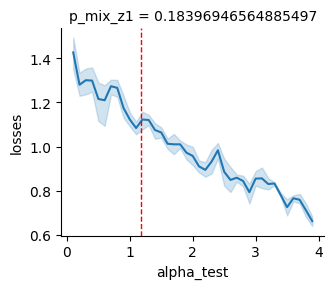

In [23]:
alpha_train = d
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=1.18, key_metric='losses')
pass

<Figure size 1200x1000 with 0 Axes>

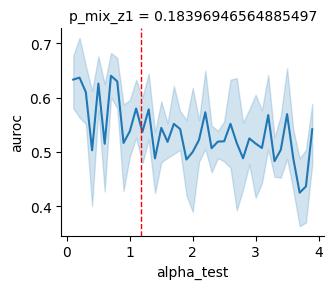

In [24]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=1.18, key_metric='auroc')
pass

<Figure size 1200x1000 with 0 Axes>

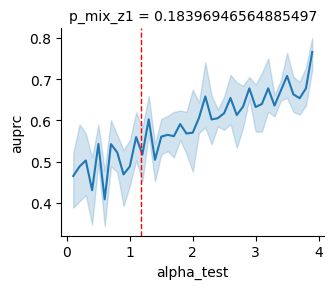

In [37]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=1.18, key_metric='auprc')
pass

<Figure size 1200x1000 with 0 Axes>

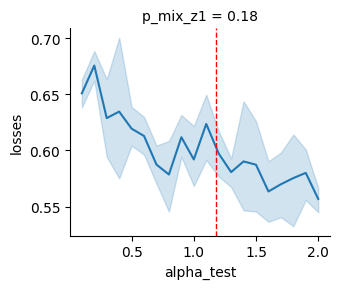

In [149]:
tmp = plotAlphaPmix(losses=losses_ls[0], alpha_train=1.18, key_metric='losses')
pass

In [136]:
losses_dict['combination'] = losses_dict['combination'][5:]

In [133]:
len(losses_dict['losses'])

20

In [130]:
losses_dict['combination']

[(0.54, 0.64, 0.18, 0.1, 4, None, 0),
 (0.54, 0.64, 0.18, 0.1, 4, None, 0),
 (0.54, 0.64, 0.18, 0.1, 4, None, 0),
 (0.54, 0.64, 0.18, 0.1, 4, None, 0),
 (0.54, 0.64, 0.18, 0.1, 4, None, 0),
 (0.54, 0.64, 0.18, 0.1, 4, None, 0),
 (0.54, 0.64, 0.18, 0.2, 4, None, 0),
 (0.54, 0.64, 0.18, 0.30000000000000004, 4, None, 0),
 (0.54, 0.64, 0.18, 0.4, 4, None, 0),
 (0.54, 0.64, 0.18, 0.5, 4, None, 0),
 (0.54, 0.64, 0.18, 0.6000000000000001, 4, None, 0),
 (0.54, 0.64, 0.18, 0.7000000000000001, 4, None, 0),
 (0.54, 0.64, 0.18, 0.8, 4, None, 0),
 (0.54, 0.64, 0.18, 0.9, 4, None, 0),
 (0.54, 0.64, 0.18, 1.0, 4, None, 0),
 (0.54, 0.64, 0.18, 1.1, 4, None, 0),
 (0.54, 0.64, 0.18, 1.2000000000000002, 4, None, 0),
 (0.54, 0.64, 0.18, 1.3, 4, None, 0),
 (0.54, 0.64, 0.18, 1.4000000000000001, 4, None, 0),
 (0.54, 0.64, 0.18, 1.5, 4, None, 0),
 (0.54, 0.64, 0.18, 1.6, 4, None, 0),
 (0.54, 0.64, 0.18, 1.7000000000000002, 4, None, 0),
 (0.54, 0.64, 0.18, 1.8, 4, None, 0),
 (0.54, 0.64, 0.18, 1.9000000000000

## Load Data Fisher

In [162]:
df_fisher = pd.read_csv('./processed_fisher.tsv', sep = '\t', index_col = 0)

In [170]:
df_fisher.head()

,conversation,speaker,text,DATE_TIME,TOPICID,SIG_GRADE,CNV_GRADE,PIN,SX.DL,PHNUM,PHSET,PHTYP,S_SEX,S_AGE,EDU,NATIVE_LANG,WHERE_RAISED,NSIDES,SIDE_DATA
0,1855,A,hello hello hi my name is betsy hi yeah w...,20030423_22:18:25,ENG29,3.0,3.5,27792,f.a,860889pik,NaN,2.0,F,43.0,15.0,English,CT,1,01855_A/f.a
1,1855,B,hello hello hi my name is ray okay this i...,20030423_22:18:25,ENG29,3.0,3.5,92397,m.a,972814eei,NaN,1.0,M,20.0,15.0,English,CA,2,01855_B/m.a;04589_B/m.a
2,1882,A,hi i'm laura okay yes it is okay well do ...,20030424_15:14:53,ENG30,4.0,3.5,85888,f.a,815485brm,NaN,2.0,F,32.0,18.0,English,IL,2,01882_A/f.a;01988_A/f.a
3,1882,B,hi laura i'm brenda this is your first time ...,20030424_15:14:53,ENG30,4.0,3.5,81482,f.a,931823sev,NaN,2.0,F,53.0,14.0,English,NY,3,01882_B/f.a;06489_B/f.a;06864_A/f.a
4,1815,A,hello this is karen hi (( good where are yo...,20030423_18:12:14,ENG29,4.0,3.0,41313,f.a,618624xpf,NaN,3.0,F,50.0,15.0,English,IL,3,01815_A/f.a;01907_A/f.a;03873_A/f.a


In [176]:
df_fisher.columns

Index(['conversation', 'speaker', 'text', 'DATE_TIME', 'TOPICID', 'SIG_GRADE',
       'CNV_GRADE', 'PIN', 'SX.DL', 'PHNUM', 'PHSET', 'PHTYP', 'S_SEX',
       'S_AGE', 'EDU', 'NATIVE_LANG', 'WHERE_RAISED', 'NSIDES', 'SIDE_DATA'],
      dtype='object')

In [172]:
df_fisher.WHERE_RAISED.value_counts()

NY          3035
CA          2601
PA          2059
TX          1084
NJ          1009
            ... 
Ghana          1
Ecuador        1
PROVINCE       1
Dominica       1
Uganda         1
Name: WHERE_RAISED, Length: 153, dtype: int64

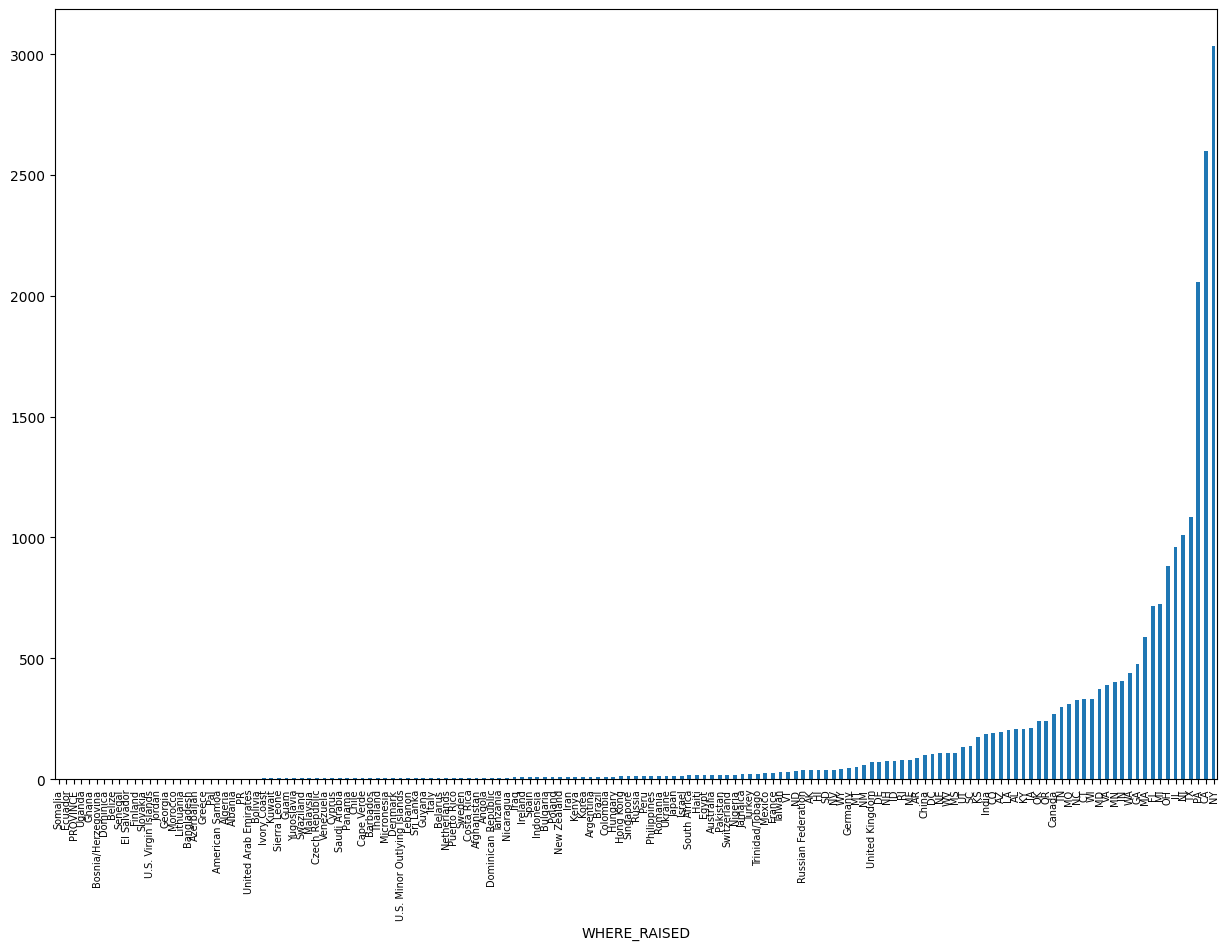

In [229]:
plt.figure(figsize = (15,10))
df_fisher.groupby("WHERE_RAISED").size().sort_values().plot.bar()
plt.xticks(fontsize=7, rotation=90)
plt.show()


In [194]:
df_fisher_us = df_fisher[df_fisher["WHERE_RAISED"].str.len()==2]

In [195]:
df_fisher_us.WHERE_RAISED.value_counts()

NY    3035
CA    2601
PA    2059
TX    1084
NJ    1009
IL     960
OH     881
MI     723
FL     715
MA     588
GA     477
WA     441
IN     405
MN     403
VA     388
MD     374
WI     332
CT     331
NC     326
MO     311
TN     300
OR     240
OK     239
IA     211
AL     206
KY     206
LA     203
AZ     194
CO     191
KS     176
SC     139
UT     132
MS     109
WV     107
NE     106
DC     102
AR      89
ME      81
RI      78
ID      76
NH      74
DE      72
NM      59
MT      49
WY      40
SD      38
NV      38
AK      36
HI      36
ND      33
VT      30
PR       2
Name: WHERE_RAISED, dtype: int64

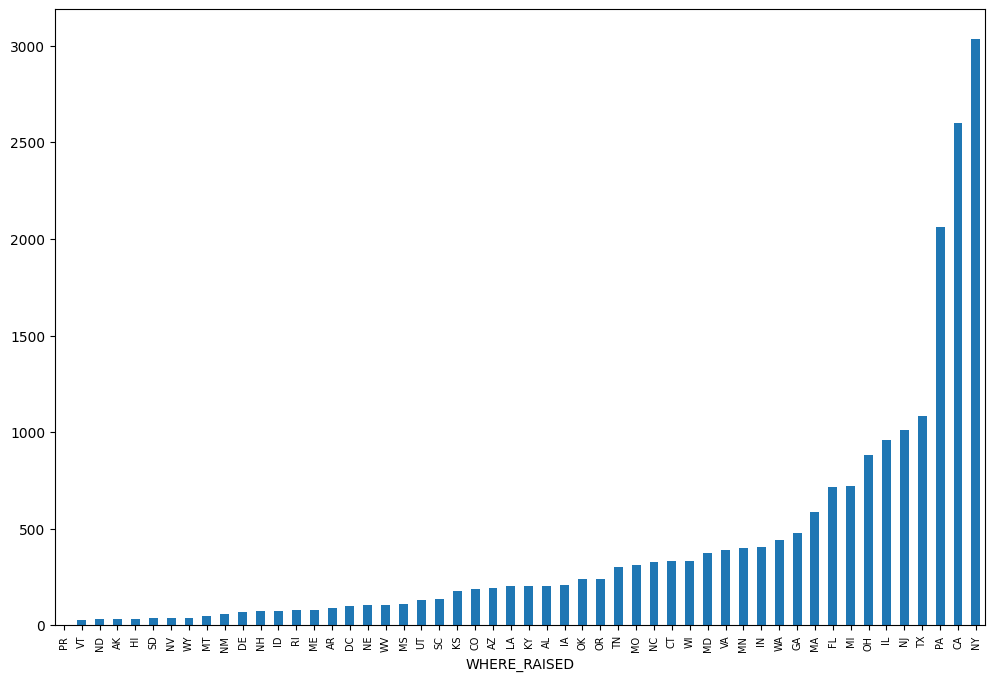

In [230]:
plt.figure(figsize = (12,8))
df_fisher_us.groupby("WHERE_RAISED").size().sort_values().plot.bar()
plt.xticks(fontsize=7, rotation=90)
plt.show()

### Select Most Prevalent Two States

In [199]:
ex_df = df_fisher_us[df_fisher_us['WHERE_RAISED'].isin(['NY', 'CA'])] 

In [203]:
ex_df = ex_df.assign(geo_loc = ex_df.WHERE_RAISED)

In [204]:
ex_df.geo_loc.value_counts()

NY    3035
CA    2601
Name: geo_loc, dtype: int64

In [249]:
ex_df.S_SEX.value_counts()

M    2927
F    2699
Name: S_SEX, dtype: int64

In [250]:
ex_df = ex_df.dropna(subset=['S_SEX','geo_loc'])

In [251]:
# z_mix_pi = 0.538
len(ex_df[ex_df['geo_loc'] == 'NY'])/len(ex_df)

0.5383931745467473

In [252]:
# p_ny = 0.499
len(ex_df[(ex_df['geo_loc'] == 'NY') & (ex_df['S_SEX'] == 'F')])/len(ex_df[ex_df['geo_loc'] == 'NY'])

0.49950478705843515

In [253]:
# p_ny = 0.456
len(ex_df[(ex_df['geo_loc'] == 'CA') & (ex_df['S_SEX'] == 'F')])/len(ex_df[ex_df['geo_loc'] == 'CA'])

0.4566807855217559

In [255]:
### Recode F/M and CA/NY
ex_df.S_SEX = ex_df.S_SEX.map({'F': 1, 'M': 0}).astype(np.int64)
ex_df.geo_loc = ex_df.geo_loc.map({'NY': 1, 'CA': 0}).astype(np.int64)

/home/sheng136/miniconda3/envs/deDTN/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [257]:
## FEMALE = 1, MALE = 0
## NY = 1, CA = 0


n_test = 200 # the number of testing examples; set to None to disable (i.e., get as many examples as possible)
n_test_error = 0


valid_high_combinations = []
valid_full_settings = []
for combination in itertools.product([0.56], 
                                    [0.499], 
                                    [0.538],
                                     np.arange(0, 10, 0.1),
                                     [4],
                                     [n_test],
                                     [n_test_error]
                                    ):
    
    ret = confoundSplitNumbers(df0=ex_df[ex_df['geo_loc'] == 0], df1=ex_df[ex_df['geo_loc'] == 1], 
                        df0_label='S_SEX', df1_label='S_SEX',

                        p_pos_train_z0=combination[0], p_pos_train_z1 = combination[1], p_mix_z1 = combination[2], alpha_test = combination[3],

                        train_test_ratio = combination[4], 
                               n_test=n_test, n_test_error=n_test_error
                       )
   
    if (ret is not None) and (ret['n_df0_train_pos'] >= 1): # valid high combos
        valid_high_combinations.append(combination)
        valid_full_settings.append(ret)

In [258]:
len(valid_high_combinations)

23

In [259]:
losses_dict = {}

losses_dict['combination'] = []
losses_dict['full_setting']=[]
losses_dict['losses'] = []
losses_dict['auroc'] = []
losses_dict['auprc'] = []
losses_dict['f1_at_05'] = []

random.seed(23)

In [261]:
valid_full_settings[0]

{'n_df0_train_pos': 208,
 'n_df0_test_pos': 79,
 'n_df0_train_neg': 163,
 'n_df0_test_neg': 14,
 'n_df1_train_pos': 215,
 'n_df1_test_pos': 27,
 'n_df1_train_neg': 216,
 'n_df1_test_neg': 80,
 'mix_param_dict': {'p_pos_train_z0': 0.56,
  'p_pos_train_z1': 0.499,
  'p_pos_train': 0.527182,
  'p_pos_test': 0.527182,
  'p_mix_z0': 0.46199999999999997,
  'p_mix_z1': 0.538,
  'alpha_train': 0.8910714285714285,
  'alpha_test': 0.30000000000000004,
  'p_pos_test_z0': 0.8456560795636832,
  'p_pos_test_z1': 0.25369682386910497,
  'C_y': 0.527182,
  'C_z': 0.538}}

In [265]:
for c,setting in tqdm(zip(valid_high_combinations, valid_full_settings), total=len(valid_high_combinations)):
    losses_dict['combination'].append(c)
    losses_dict['full_setting'].append(setting)
    
    losses = []
    _auroc = []
    _auprc = []    
    _f1_at_05 = []
    
    for i in range(5):
        _rand = random.randint(0,1000)    

        combination = c
        # combination = (0.201, 0.6, 0.3, 1.0, 4)
        # combination = (0.201, 0.7, 0.5, 1.4, 4)
        ret = confoundSplitDF(df0=ex_df[ex_df['geo_loc'] == 0], df1 =ex_df[ex_df['geo_loc'] == 1], 
                              df0_label='S_SEX', df1_label='S_SEX',
                              p_pos_train_z0=combination[0], 
                              p_pos_train_z1 = combination[1], 
                              p_mix_z1 = combination[2], 
                              alpha_test = combination[3],
                              train_test_ratio = combination[4],
                              random_state= _rand,
                              n_test=combination[5],
                              n_test_error=combination[6]
                                   )

        df_train = pd.concat(
                [
                    ret["sample_df0_train"][["text", "S_SEX"]],
                    ret["sample_df1_train"][["text", "S_SEX"]],
                ],
                ignore_index=True,
            )

        df_test = pd.concat(
                [
                    ret["sample_df0_test"][["text", "S_SEX"]],
                    ret["sample_df1_test"][["text", "S_SEX"]],
                ],
                ignore_index=True,
            )


        X_train = df_train["text"]
        y_train = df_train[["S_SEX"]]

        X_test = df_test["text"]
        y_test = df_test[["S_SEX"]]



 
        model = NeuralSingleLabelModel(**model_config)

        model.load_pretrained()

        model.trainModel(
                X=X_train, y=y_train, device="cuda:0"
            )



        y_pred, y_prob = model.predict(
                X=X_test, device="cuda:0"
            )

        

        # collect metrics: loss, auroc, auprc, f1
        loss = torch.nn.NLLLoss()

        _loss = loss(
            torch.log(torch.tensor(y_prob.values)),
            torch.tensor(y_test.values).squeeze(1),
        )

        losses.append(_loss.item())

        
        _auroc.append(
            metrics.roc_auc_score(
                y_true=y_test.values,
                y_score=y_prob.max(axis = 1),
            )
        )
        _auprc.append(
            metrics.average_precision_score(
                y_true=y_test.values,
                y_score=y_prob.max(axis = 1),
            )
        )
        #_f1_at_05.append(metrics.f1_score(y_true=y_test.values, y_pred=y_pred))
    
    losses_dict['losses'].append(losses)
    losses_dict['auroc'].append(_auroc)
    losses_dict['auprc'].append(_auprc)

  0%|          | 0/23 [00:00<?, ?it/s]

/home/sheng136/miniconda3/envs/deDTN/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/sheng136/miniconda3/envs/deDTN/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/sheng136/miniconda3/envs/deDTN/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn